<h1><big><center>Image denoising using pycobra</center></big></h1>
<h4><big><center> Master MVA : Graph in machine learning project</center></big></h4>

<h3><big><center>Juliette Rengot</center></big></h3>
<h3><big><center>Supervised by  Benjamin Guedj</center></big></h3>

<big>**Goal**</big>

We aim at improving the denoising of an image using the aggregation method implemented in pycobra library.

# Import and download 

In [18]:
import numpy as np
import cv2
import skimage.restoration
import scipy.ndimage
import matplotlib.pyplot as plt
from google.colab import files

!pip install pycobra
from pycobra.cobra import Cobra
from pycobra.diagnostics import Diagnostics

import warnings
warnings.filterwarnings("ignore")

In [19]:
print("Choose images to form a train set")
uploaded = files.upload()
train_names = list(uploaded.keys())

Choose images to form a train set


Saving lena.png to lena (4).png


In [20]:
print("Choose a test image")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

Choose a test image


Saving lena.png to lena (5).png


# Noise module

Here, we want to add artificial noise of different kinds to images.

We implement the most basic approaches :

1. Gaussian noise
2. Salt and Pepper noise
3. Poisson noise
4. Speckle noise
5. Random patch suppression

In [0]:
class noisyImage :
    def __init__(self, path, file_name,                    # original image information
                 color=0,                                  # if 1 use color image, if 0 use grayscale image
                 gauss_mu=0, gauss_sigma=0.3,               # default parameters for gaussian noise
                 sp_ratio=0.5, sp_amount=0.004,             # default parameters for salt and pepper noise
                 suppr_patch_size=1, suppr_patch_nb=1,     # default parameters for random patch suppression
                 verbose = False):                          # If True, print values of noisy images when computed         
        """ Create a class gathering all noisy version of an original image
        PARAMETERS
        path : path where is located the original image
        file_name : name of the original image
        gauss_mu : mean of gaussian noise
        gauss_sigma : variance of gaussian noise
        """
        
        self.verbose = verbose
        self.str2int = {"gaussian" : 0, "salt_pepper" : 1, "poisson" : 2, "speckle" : 3, "suppression" : 4, "multi" : 5}
        self.int2str = {0 : "gaussian", 1 : "salt_pepper", 2 : "poisson", 3 : "speckle", 4 : "suppression", 5 : "multi"}
        self.method_nb = len(self.str2int)                 # How many denoising methods are available 
        self.Ilist = [None for i in range(self.method_nb)] # List of all available noisy images
        
        self.name = path+file_name
        assert(color==0 or color==1)
        original = cv2.imread(self.name, color)
        if (np.max(original)!=np.min(original)):
            self.Ioriginal = (original-np.min(original))/(np.max(original)-np.min(original))
        else:
            self.Ioriginal = original
            
        self.shape = (self.Ioriginal).shape
        self.size = (self.Ioriginal).size
    
        self.mu = gauss_mu
        self.sigma = gauss_sigma
        self.Igauss = np.empty(self.shape)

        self.s_vs_p = sp_ratio
        self.amount = sp_amount
        self.Isp = np.empty(self.shape)
        
        self.Ipoiss = np.empty(self.shape)
        
        self.Ispeckle = np.empty(self.shape)
        
        self.patch_size=suppr_patch_size
        self.patch_nb=suppr_patch_nb
        self.Isuppr = np.empty(self.shape)

        self.Imulti = np.empty(self.shape)
        
    def add_gauss(self):
        """ Add gaussian noise to the original image """
        I_gauss = np.random.normal(self.mu, self.sigma, self.shape)
        I_gauss = self.Ioriginal+I_gauss
        if (np.max(I_gauss)!=np.min(I_gauss)):
            I_gauss = (I_gauss-np.min(I_gauss))/(np.max(I_gauss)-np.min(I_gauss))
        self.Igauss = I_gauss
        self.Ilist[0] = I_gauss
        
        if self.verbose :
            print("Gauss ", self.Igauss)
        return()
    
    def salt_and_pepper(self):
        """ Apply salt and pepper noise on the original image """
        I_sp = np.copy(self.Ioriginal)
        # Salt mode
        num_salt = np.ceil(self.amount * self.size * self.s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in self.shape]
        I_sp[tuple(coords)] = 1
        # Pepper mode
        num_pepper = np.ceil(self.amount* self.size * (1. - self.s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in self.shape]
        I_sp[tuple(coords)] = 0
        
        if (np.max(I_sp)!=np.min(I_sp)) :
            I_sp = (I_sp-np.min(I_sp))/(np.max(I_sp)-np.min(I_sp))    
        self.Isp = I_sp
        self.Ilist[1]=self.Isp
        
        if self.verbose :
            print("Salt and pepper ", self.Isp)
        return()
        
    def poisson(self):
        """ Apply noise with poisson distribution on the original image """
        val = len(np.unique(self.Ioriginal))
        val = 2 ** np.ceil(np.log2(val))
        I_poisson = np.random.poisson(self.Ioriginal*val)/float(val)
        
        if (np.max(I_poisson)!=np.min(I_poisson)): 
            I_poisson = (I_poisson-np.min(I_poisson))/(np.max(I_poisson)-np.min(I_poisson))
        self.Ipoiss = I_poisson
        self.Ilist[2]=self.Ipoiss
        if self.verbose :
            print("Poisson ", self.Ipoiss)
        return()
    
    def speckle(self):
        """ Apply speckle noise on the original image """
        if len(self.shape) == 2 :
            gauss = np.random.randn(self.shape[0],self.shape[1])
        if len(self.shape) == 3 :
            gauss = np.random.randn(self.shape[0], self.shape[1], self.shape[2])
        I_speckle = self.Ioriginal + self.Ioriginal * gauss
        
        if (np.max(I_speckle)!=np.min(I_speckle))  :
            I_speckle = (I_speckle-np.min(I_speckle))/(np.max(I_speckle)-np.min(I_speckle))
        self.Ispeckle = I_speckle
        self.Ilist[3]=self.Ispeckle
        if self.verbose :
            print("Speckle ", self.Ispeckle)
        return()
    
    def suppr(self, I):
        """ Suppress random patch from an image I """
        I_lack=np.copy(I)
        for i in range(self.patch_nb):
            x = np.random.randint(0,self.shape[0]-self.patch_size)
            y = np.random.randint(0,self.shape[1]-self.patch_size)
            I_lack[x:x+self.patch_size,y:y+self.patch_size]=1
        return(I_lack)
        
    def random_patch_suppression(self):
        """ Suppress random patch from the original image """
        Isuppr = self.suppr(self.Ioriginal)
        self.Isuppr = Isuppr
        self.Ilist[4] = self.Isuppr
        if self.verbose :
            print("Random patch suppression ", self.Isuppr)
        return()
        
    def all_noise(self):
         """Apply all available noise methods on the original image """
         self.add_gauss()
         self.salt_and_pepper()
         self.poisson()
         self.speckle()
         self.random_patch_suppression()
    
    def multi_noise(self):
        self.all_noise()
        Imulti = np.zeros(self.shape)
        Imulti[0:self.shape[0]//2, 0:self.shape[1]//2] = self.Igauss[0:self.shape[0]//2, 0:self.shape[1]//2]
        Imulti[0:self.shape[0]//2, self.shape[1]//2:self.shape[1]] = self.Isp[0:self.shape[0]//2, self.shape[1]//2:self.shape[1]]
        Imulti[self.shape[0]//2:self.shape[0], 0:self.shape[1]//2] = self.Ipoiss[self.shape[0]//2:self.shape[0], 0:self.shape[1]//2]
        Imulti[self.shape[0]//2:self.shape[0], self.shape[1]//2:self.shape[1]] = self.Ispeckle[self.shape[0]//2:self.shape[0], self.shape[1]//2:self.shape[1]]
        Imulti = self.suppr(Imulti)
        self.Imulti = Imulti
        self.Ilist[5] = self.Imulti
        if self.verbose :
            print("Multi noise ", self.Imulti)
        return
     
    def show(self, I, title=''):
        """ Display the image I with window entitled 'title' """
        cv2.imshow(title, I)
        cv2.waitKey(0)
        cv2.destroyAllWindows() 
        
    def all_show(self):
         """Create and show all possible noise images """
         self.multi_noise()
         print("Salt and Pepper noise")
         self.show(self.Isp, "Salt and Pepper noise")
         print("Speckle noise noise")
         self.show(self.Ispeckle, "Speckle noise noise")
         print("Poisson noise")
         self.show(self.Ipoiss, "Poisson noise")
         print("Gaussian additive noise")
         self.show(self.Igauss, "Gaussian additive noise")
         print("Missing part")
         self.show(self.Isuppr,"Missing part")
         print("Multi noise")
         self.show(self.Imulti,"Multi noise")

Original Image


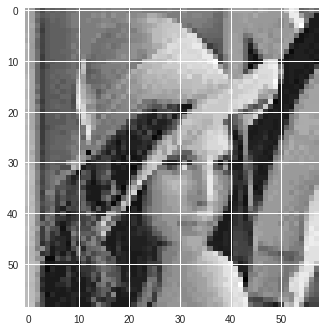

gaussian


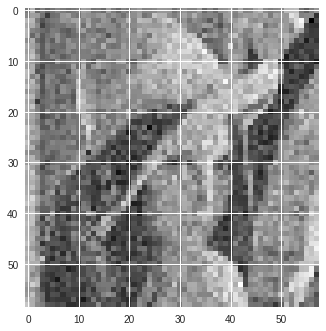

salt_pepper


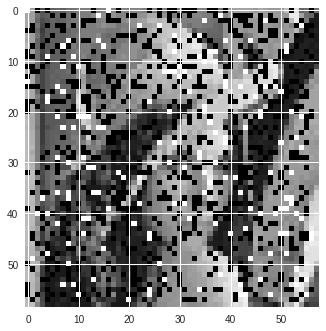

poisson


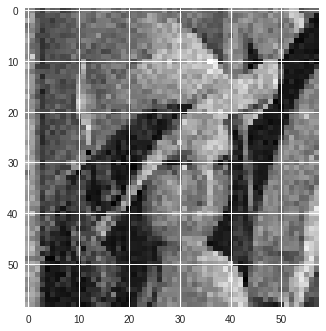

speckle


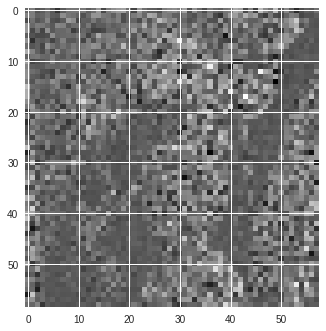

suppression


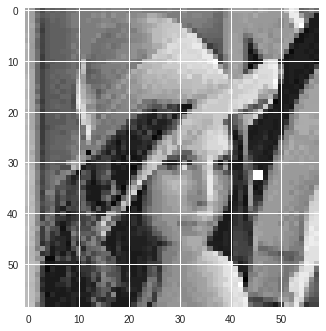

multi


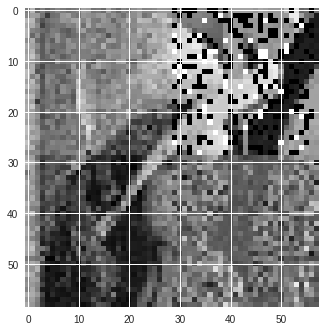

In [22]:
color = 0
noise_class = noisyImage('', file_name, color, 0.5, 0.1, 0.2, 0.3, 2, 1)
noise_class.multi_noise()

print('Original Image')
plt.imshow(noise_class.Ioriginal, cmap = plt.get_cmap('gray'))
plt.show()

for i in range(noise_class.method_nb) :
  print(noise_class.int2str[i])
  plt.imshow(noise_class.Ilist[i], cmap = plt.get_cmap('gray'))
  plt.show()

In [23]:
#Choose which noise to apply to your image
print("You choose the noise of type : ", noise_class.int2str[5])
im_noise = noise_class.Ilist[0]

training_noise_kind = [i for i in range(noise_class.method_nb)]
print("You choose to train on data with noise of type : ")
for i in training_noise_kind :
  print(noise_class.int2str[i])

You choose the noise of type :  multi
You choose to train on data with noise of type : 
gaussian
salt_pepper
poisson
speckle
suppression
multi


# Denoise module

Here, we want to remove artificial noise from noisy images.

We implement the most basic approaches :
0. Bilateral filter
1. Non local means
2. Gaussian filter
3. Median filter
4. Tv Chambolle
5. Richardson Lucy deconvolution
6. Inpainting



In [0]:
class denoisedImage :
    def __init__(self, noisy, original=None, color=0,
                 gauss_sigma=0.8,   #default parameter for gaussian filter
                 median_size=3,     #default parameter for the median filter
                 point_spread_rl=5, #default parameter for the richardson lucy deconvolution
                 verbose = False):  #If True, print values of denoised images when computed         
        """ Create a class gathering all denoised version of a noisy image
        PARAMETERS
        noisy : noisy image
        original : original version of the noisy image if available
        gauss_sigma : standard deviation for the gaussian filter
        """
        self.verbose = verbose
        self.str2int = {"bilateral" : 0, "nl_means" : 1, "gaussian" : 2, "median" : 3, "tv_chambolle" : 4, "richardson_lucy" : 5, "inpainting" : 6}
        self.int2str = {0 : "bilateral", 1 : "nl_means", 2 : "gaussian", 3 : "median", 4 : "tv_chambolle", 5 : "richardson_lucy", 6 : "inpainting"}
        self.method_nb = len(self.str2int)                 # How many denoising methods are available 
        self.Ilist = [None for i in range(self.method_nb)] # List of all available denoised images
        
        self.color = color
        
        self.Inoisy = noisy
        self.shape = self.Inoisy.shape
            
        self.Ioriginal = original
        
        self.Ibilateral = np.empty(self.shape)
        
        self.Inlmeans = np.empty(self.shape)
        
        self.gauss_sigma = gauss_sigma
        self.Igauss = np.empty(self.shape)
        
        self.median_size = median_size
        self.Imedian = np.empty(self.shape)
        
        self.Ichambolle = np.empty(self.shape)
        
        self.point_spread_rl = point_spread_rl
        self.Irl = np.empty(self.shape)

        self.Iinpaint = np.empty(self.shape)
               
    def bilateral(self):        
        """ Apply a bilateral filter on the noisy image """
        if self.color==0 :
            self.Ibilateral = skimage.restoration.denoise_bilateral(self.Inoisy, multichannel=False)
        else :
            self.Ibilateral = skimage.restoration.denoise_bilateral(self.Inoisy, multichannel=True)
        self.Ilist[self.str2int['bilateral']] = self.Ibilateral
        if self.verbose :
            print('Bilateral :', self.Ibilateral)
        return()
    
    def NLmeans(self):
        """ Apply a Non-local means denoising on the noisy image """
        if self.color==0 :
            self.Inlmeans = skimage.restoration.denoise_nl_means(self.Inoisy, multichannel=False)
        else :
            self.Inlmeans = skimage.restoration.denoise_nl_means(self.Inoisy, multichannel=True)
        self.Ilist[self.str2int['nl_means']] = self.Inlmeans
        if self.verbose :
            print('Non-local means :', self.Inlmeans)
        return()
    
    def gauss(self):
        """ Apply a gaussian filter on the noisy image """
        self.Igauss = scipy.ndimage.gaussian_filter(self.Inoisy, self.gauss_sigma)
        self.Ilist[self.str2int['gaussian']] = self.Igauss
        if self.verbose :
            print('gauss :', self.Igauss)
        return()
    
    def median(self):
        """ Apply a median filter on the noisy image """
        self.Imedian = scipy.ndimage.median_filter(self.Inoisy, self.median_size)
        self.Ilist[self.str2int['median']] = self.Imedian
        if self.verbose :
            print('med ', self.Imedian)
        return()

    def TVchambolle(self):
        """ Perform total-variation denoising on n-dimensional images. """
        if self.color==0 :
            self.Ichambolle = skimage.restoration.denoise_tv_chambolle(self.Inoisy, multichannel=False)
        else :
            self.Ichambolle = skimage.restoration.denoise_tv_chambolle(self.Inoisy, multichannel=True)
        self.Ilist[self.str2int['tv_chambolle']] = self.Ichambolle
        if self.verbose :
            print('TV chambolle :', self.Ichambolle)
        return()

    def richardson_lucy(self):
        """Richardson-Lucy deconvolution."""
        psf = np.ones((self.point_spread_rl, self.point_spread_rl)) / self.point_spread_rl**2
        if self.color == 0:
            I = skimage.restoration.richardson_lucy(self.Inoisy, psf, self.point_spread_rl)
        else:
            I = np.zeros(self.shape)
            I[:,:,0] =  skimage.restoration.richardson_lucy(self.Inoisy[:,:,0], psf, self.point_spread_rl)
            I[:,:,1] =  skimage.restoration.richardson_lucy(self.Inoisy[:,:,1], psf, self.point_spread_rl)
            I[:,:,2] =  skimage.restoration.richardson_lucy(self.Inoisy[:,:,2], psf, self.point_spread_rl)
        self.Irl = I
        self.Ilist[self.str2int['richardson_lucy']] = self.Irl
        if self.verbose :
            print('Richardson Lucy :', self.Irl)
        return()

    def inpaint(self):
        """Inpainting"""
        
        if self.color == 0:
            mask = (self.Inoisy==1)
            I = skimage.restoration.inpaint.inpaint_biharmonic(self.Inoisy, mask, multichannel=False)
        else:
            mask = (self.Inoisy.mean(axis=2)==1)
            I = skimage.restoration.inpaint.inpaint_biharmonic(self.Inoisy, mask, multichannel=True)            

        self.Iinpaint = I
        self.Ilist[self.str2int['inpainting']] = self.Iinpaint
        if self.verbose :
            print('Inpainting :', self.Iinpaint)
        return()
    
    def all_denoise(self):
        """Apply all available denoise methods on the noisy image """
        self.bilateral()
        self.NLmeans()
        self.gauss()
        self.median()
        self.TVchambolle()
        self.richardson_lucy()
        self.inpaint()
        return()
    
    def show(self, I, title=''):
        """ Display the image I with window entitled 'title' """
        cv2.imshow(title, I)
        cv2.waitKey(0)
        cv2.destroyAllWindows() 
        return()
    
    def all_show(self):
         """Create and show all possible denoised images of the noisy image """
         self.all_denoise()
         self.show(self.Ibilateral, "Bilateral filter")
         self.show(self.Inlmeans, "Non-local means denoising")
         self.show(self.Igauss, "Gaussian Filter")
         self.show(self.Imedian, "Median Filter")
         self.show(self.Ichambolle, "TVchambolle")
         self.show(self.Irl, "Richardson Lucy deconvolution")
         self.show(self.Iinpaint, "Inpainting")
         return()

bilateral


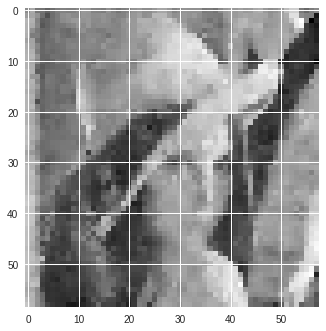

nl_means


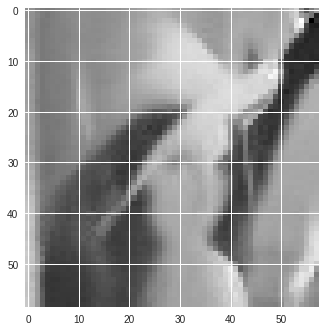

gaussian


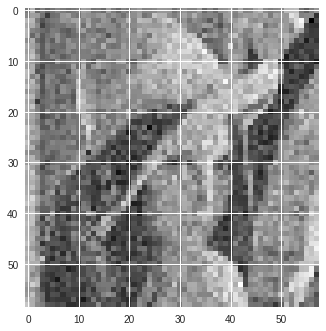

median


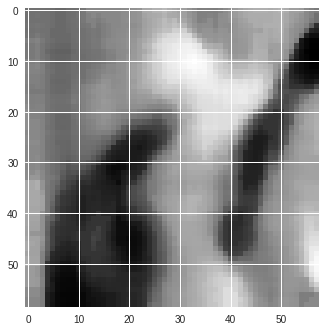

tv_chambolle


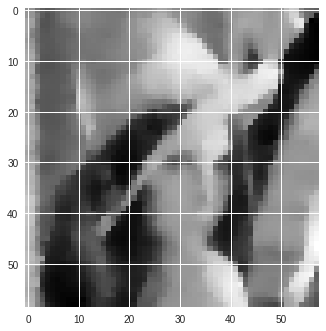

richardson_lucy


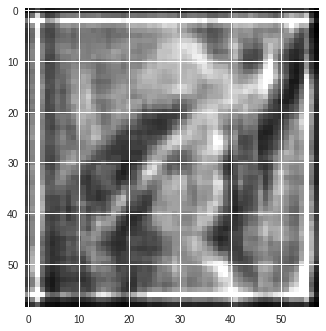

inpainting


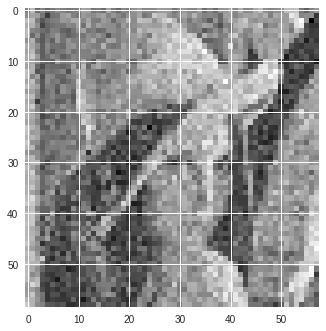

In [25]:
#Exemple of denoising
denoise_class = denoisedImage(im_noise, noise_class.Ioriginal, color, gauss_sigma=0.1, median_size=10)
denoise_class.all_denoise()

for i in range(denoise_class.method_nb) :
  print(denoise_class.int2str[i])
  plt.imshow(denoise_class.Ilist[i], cmap = plt.get_cmap('gray'))
  plt.show()

# Evaluation module

Here, we implement the basic metrics to evaluate the denoising performances :


1.   PSNR :  Peak signal-to-noise ratio
2.   RMSE :  Root Mean Square Error 



In [0]:
class eval_denoising :
    def __init__(self, I1, I2,   # I1 and I2 are the two images to compare
                 PSNR_peak=255):     # default value for PSNR
        self.I1 = I1    #result
        self.I2 = I2    #objective
        self.Idiff = I2 - I1
        
        self.euclidian_distance = None
        
        self.peak = PSNR_peak
        self.PSNR = None
        
        self.RMSE = None
      
    def compute_euclidian_distance(self):
        """
        Compute euclidian distance between two images
        """
        self.euclidian_distance = np.linalg.norm(self.I1 - self.I2)
        return()
    
    def compute_PSNR(self):
        """
        Computes the PSNR 'metric' between two images assumed to be in the range [0,1]
        """
        x = ((np.array(self.I1).squeeze() - np.array(self.I2).squeeze()).flatten())
        self.PSNR = 10*np.log10(self.peak**2 / np.mean(x**2))
        return ()
    
    def compute_RMSE(self):
        """
        Computes the RMSE 'metric' between two images
        """
        self.RMSE = np.sqrt(((self.I1 - self.I2) ** 2).mean())
        return ()
    
    def all_evaluate(self):
        """
        Compute and display all available results
        """
        self.compute_euclidian_distance()
        print("Euclidian distance : ", self.euclidian_distance)
        self.compute_PSNR()
        print("PSNR : ", self.PSNR)
        self.compute_RMSE()
        print("RMSE : ", self.RMSE)
        print('')
        return()

In [27]:
#Evaluation example
for i in range(denoise_class.method_nb) :
  print(denoise_class.int2str[i])
  evaluate = eval_denoising(denoise_class.Ilist[i], denoise_class.Ioriginal)
  evaluate.all_evaluate()

bilateral
Euclidian distance :  5.847909298475939
PSNR :  68.13359109950702
RMSE :  0.09996791297485129

nl_means
Euclidian distance :  7.698324775645266
PSNR :  65.74567907896119
RMSE :  0.13160010218086216

gaussian
Euclidian distance :  6.182007429110083
PSNR :  67.65101320807491
RMSE :  0.10567920074345587

median
Euclidian distance :  9.53699687723435
PSNR :  63.88537085212239
RMSE :  0.16303154259134323

tv_chambolle
Euclidian distance :  6.8654771942267265
PSNR :  66.74018908384997
RMSE :  0.11736287135338298

richardson_lucy
Euclidian distance :  11.558446982283144
PSNR :  62.215613955396314
RMSE :  0.1975875074448315

inpainting
Euclidian distance :  6.192737494374104
PSNR :  67.63595024126205
RMSE :  0.10586262736240287



# Use of Cobra

In this part, we define a new model to aggregate efficacly the prevous denoising methods

First, we create function to load and reshape training data. list_neighnours is used when we work with patchs

In [0]:
#load and reshape the training data 
def list_neighbours(I,x,y,k):
    """
    INPUT
    I : image
    x,y : coordinates of the central pixel of the consider patch
    k : patch of size (2*k+1)(2*k+1)
    
    OUPUT
    L : list of I(x',y') where (x',y') is a pixel of the patch
    """
    assert(0<=x-k)
    assert(x+k<I.shape[0])
    assert(0<=y-k)
    assert(y+k<I.shape[1])
    
    L = []
    for x1 in range(x-k, x+k+1):
        for y1 in range(y-k, y+k+1):
            L.append(I[x1,y1])
    return(L)

def load_training_data(train_names, noise_kind, k=0):
    """ Load images, apply noise methods on it and
    return three different training sets.
    
    INPUT
    train_names : list containing the name of images used to train the model
    k : patch of size (2*k+1)(2*k+1) => (2*k+1)(2*k+1) features
    
    OUTPUT
    Xtrain : list of pixel of noisy images
    Xtrain1 : list of pixel of noisy images +  gaussian noise
    Xtrain2 : list of pixel of noisy images - gaussian noise
    Ytrain : list of pixel of original images
    """
    Xtrain  = []
    Xtrain1 = []
    Xtrain2 = []
    Ytrain  = []
    for file in train_names :
        noise_class = noisyImage('', file, 0, 0.5, 0.1, 0.2, 0.3, 2, 1)
        noise_class.multi_noise()
        for i in noise_kind:
            Ytrain += [[noise_class.Ioriginal[x, y]] for x in range(k,noise_class.shape[0]-k) for y in range(k,noise_class.shape[1]-k)]
            Inoisy = noise_class.Ilist[i]
            
            sigma = 0.1 # gaussian noise
            eps = np.random.normal(0, sigma, noise_class.shape)
            y1 = Inoisy + sigma * eps
            y1 = (y1-y1.min())/(y1.max()-y1.min())
            y2 = Inoisy - sigma * eps
            y2 = (y2-y2.min())/(y2.max()-y2.min())
            
            Xtrain  += [list_neighbours(Inoisy, x, y, k) for x in range(k,noise_class.shape[0]-k) for y in range(k,noise_class.shape[1]-k)]
            Xtrain1 += [list_neighbours(y1, x, y, k) for x in range(k,noise_class.shape[0]-k) for y in range(k,noise_class.shape[1]-k)]
            Xtrain2 += [list_neighbours(y2, x, y, k) for x in range(k,noise_class.shape[0]-k) for y in range(k,noise_class.shape[1]-k)]
    return(Xtrain, Xtrain1, Xtrain2, Ytrain)

Next, we define the machines we will use in the cobra model.

In [0]:
class machine:
    def __init__(self, name, num_denoised_method, patch_size):
        self.name = name
        self.num_denoised_method = num_denoised_method
        self.patch_size = patch_size
        
    def predict(self, Inoisy) :     
        #print("Predict in machine :", self.name)
        Inoisy = np.array(Inoisy)
        Idenoised = []
        
        if len(Inoisy.shape)==1:
          iter_max = 1
        else:
          iter_max = Inoisy.shape[0]
        
        for i in range(iter_max):
          if len(Inoisy.shape)==1:
            image_noisy = Inoisy.reshape((2*self.patch_size+1, 2*self.patch_size+1))
          else:
            image_noisy = Inoisy[i].reshape((2*self.patch_size+1, 2*self.patch_size+1))
          
#          if image_noisy.shape != (1, 1) and not np.all(image_noisy==1):
#              denoise_class = denoisedImage(image_noisy)
#              denoise_class.inpaint()
#              image_noisy = denoise_class.Iinpaint
#              print(np.all(denoise_class.Iinpaint==image_noisy))
              
          if self.name == 'bilateral' :
              denoise_class = denoisedImage(image_noisy)
              denoise_class.bilateral()
              image_denoised = denoise_class.Ibilateral            
          elif self.name == 'nlmeans' :
              denoise_class = denoisedImage(image_noisy)
              denoise_class.NLmeans()
              image_denoised = denoise_class.Inlmeans
          elif self.name == 'gauss' :
              denoise_class = denoisedImage(image_noisy)
              denoise_class.gauss()
              image_denoised = denoise_class.Igauss            
          elif self.name == 'median' :
              denoise_class = denoisedImage(image_noisy)
              denoise_class.median()
              image_denoised = denoise_class.Imedian
          elif self.name == 'TVchambolle' :
              denoise_class = denoisedImage(image_noisy)
              denoise_class.TVchambolle()
              image_denoised = denoise_class.Ichambolle
          elif self.name == 'richardson_lucy' :
              denoise_class = denoisedImage(image_noisy)
              denoise_class.richardson_lucy()
              image_denoised = denoise_class.Irl
          elif self.name == 'inpainting' :
              if image_noisy.shape == (1, 1) or np.all(image_noisy==1):
                  image_denoised = image_noisy
              else :
                  denoise_class = denoise.denoisedImage(image_noisy)
                  denoise_class.inpaint()
                  image_denoised = denoise_class.Iinpaint
          else :
            print("Unknown name : ", self.name)
            return()
          
          if self.patch_size>0:
            Idenoised.append([image_denoised[self.patch_size, self.patch_size]])
          else :
            Idenoised.append([image_denoised])
        return(Idenoised)

We define our model.

In [0]:
def define_cobra_model(train_names, training_noise_kind, im_shape, patch_size=1, optimi=True, verbose=False) :
    """
    Train a cobra model for denoising task
    
    INPUT :
    train_names : list containing the name of images used to train the model
    patch_size : use patch of size (2*patch_size+1)*(2*patch_size+1) as features
    verbose : print or not information during the training
        
    OUTPUT :
    cobra : trained model
    """
    #initial cobra parameters
    Alpha = 4     #how many machines must agree
    Epsilon = 0.2 # confidence parameter
    
    print("Training cobra model...")
    Xtrain, Xtrain1, Xtrain2, Ytrain = load_training_data(train_names, training_noise_kind, patch_size)
    cobra = Cobra(epsilon=Epsilon, machines=Alpha) # create a cobra machine
    #cobra.fit(Xtrain, Ytrain, default=False, X_k=Xtrain1, X_l=Xtrain2, y_k=Ytrain, y_l=Ytrain) # fit the cobra machine with our data
    cobra.fit(Xtrain, Ytrain) # fit the cobra machine with our data

    print("Loading machines...")
    cobra.load_machine('bilateral', machine('bilateral', 0, patch_size))
    cobra.load_machine('nlmeans', machine('nlmeans', 1, patch_size))
    cobra.load_machine('gauss', machine('gauss', 2, patch_size))
    cobra.load_machine('median', machine('median', 3, patch_size))
    cobra.load_machine('TVchambolle', machine('TVchambolle', 4, patch_size))
    cobra.load_machine('richardson_lucy', machine('richardson_lucy', 5, patch_size))
    cobra.load_machine('inpainting', machine('inpainting', 6, patch_size))

    print("Loading machine predictions...")
    cobra.load_machine_predictions() #agregate
    if verbose :
        print(cobra.machine_predictions_)
   
    if optimi : 
        print("Parameter optimisation")
        Y = cobra.predict(Xtrain[0:10])
        cobra_diagnostics = Diagnostics(cobra, Xtrain[0:10], Ytrain[0:10])
        Epsilon_opt, MSE = cobra_diagnostics.optimal_epsilon(Xtrain[0:10], Ytrain[0:10], line_points=100, info=False)
        Alpha_opt, MSE = cobra_diagnostics.optimal_alpha(Xtrain[0:10], Ytrain[0:10], epsilon=Epsilon_opt, info=False)
        if verbose :
            print("epsilon = ", Epsilon_opt)
            print("alpha = ", Alpha_opt)

        print("Training cobra model again...")
        cobra = Cobra(epsilon=Epsilon_opt, machines=Alpha_opt)
        cobra.fit(Xtrain, Ytrain, default=False, X_k=Xtrain1, X_l=Xtrain2, y_k=Ytrain, y_l=Ytrain)
        cobra.load_machine('bilateral', machine('bilateral', 0, patch_size))
        cobra.load_machine('nlmeans', machine('nlmeans', 1, patch_size))
        cobra.load_machine('gauss', machine('gauss', 2, patch_size))
        cobra.load_machine('median', machine('median', 3, patch_size))
        cobra.load_machine('TVchambolle', machine('TVchambolle', 4, patch_size))
        cobra.load_machine('richardson_lucy', machine('richardson_lucy', 5, patch_size))
        cobra.load_machine('inpainting', machine('inpainting', 6, patch_size))
        cobra.load_machine_predictions()
        if verbose :
            print("Loading machine predictions...")
            print(cobra.machine_predictions_)

    return(cobra, Alpha, Epsilon)

We now can denoise our image.

In [0]:
def denoise_cobra(im_noise, model, n_machines, patch_size=1, verbose=False) :
    """
    Denoise an noisy image using cobra aggregation
    
    INPUT :
    im_noise : noisy image
    model : trained cobra model
    n_machines : optimal number of machines to take into account in the aggregation
    patch_size : use patch of size (2*patch_size+1)*(2*patch_size+1) as features
    verbose : print or not information during the training
        
    OUTPUT :
    Y : denoised image
    """    
    print("Image denoising...")
    Xtest = [list_neighbours(im_noise, x, y, patch_size) for x in range(patch_size, noise_class.shape[0]-patch_size) for y in range(patch_size,noise_class.shape[1]-patch_size)]
    Y = model.predict(Xtest, n_machines)
    #Padding
    if patch_size > 0 :
      Y_sol = im_noise.copy()
      for x in range(patch_size, noise_class.shape[0]-patch_size) :
        for y in range(patch_size,noise_class.shape[1]-patch_size) : 
          Y_sol[x, y] = Y[(x-patch_size)*(noise_class.shape[1]-2*patch_size)+(y-patch_size)]
      Y = Y_sol.reshape(-1)
      
    if verbose :
        print("The denoised matrix has the following data matrix : ")
        print(Y)
        
    return(Y)

# Results

We can have to look to what we obtain and evaluate how good is the result.

In [32]:
patch = 0
cobra_model, Alpha, Epsilon = define_cobra_model(train_names, training_noise_kind, im_noise.shape, patch_size=patch, optimi=False, verbose=True)
Y = denoise_cobra(im_noise, cobra_model, Alpha, patch_size=patch, verbose=False)
im_denoise = np.array(Y).reshape(im_noise.shape)

Training cobra model...
Loading machines...
Loading machine predictions...
{'lasso': array([0.42666938, 0.52033501, 0.3859593 , ..., 0.45323594, 0.44107258,
       0.44250147]), 'tree': array([0.2371134 , 0.67010309, 0.14948454, ..., 0.43814433, 0.2371134 ,
       0.12886598]), 'ridge': array([0.39872528, 0.54892269, 0.33344468, ..., 0.44132606, 0.42182152,
       0.42411281]), 'random_forest': array([0.21391753, 0.67164948, 0.17268041, ..., 0.42113402, 0.28762887,
       0.22268041]), 'bilateral': [[array([[0.31984733]])], [array([[0.52858988]])], [array([[0.22912113]])], [array([[0.30140768]])], [array([[0.29028951]])], [array([[0.35603036]])], [array([[0.54755179]])], [array([[0.45053641]])], [array([[0.37583871]])], [array([[0.26914647]])], [array([[0.46810916]])], [array([[0.53418441]])], [array([[0.5252891]])], [array([[0.51979657]])], [array([[0.35207314]])], [array([[0.32238093]])], [array([[0.54968654]])], [array([[0.33814219]])], [array([[0.35733844]])], [array([[0.25842429]]

Display of the cobra denoising result


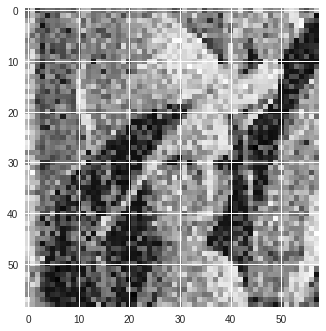

In [33]:
print('Display of the cobra denoising result')
plt.imshow(im_denoise, cmap = plt.get_cmap('gray'))

In [34]:
print("Evaluation...")
evaluate = eval_denoising(im_denoise, noise_class.Ioriginal)
evaluate.all_evaluate()

Evaluation...
Euclidian distance :  7.982253617574242
PSNR :  65.43109321341055
RMSE :  0.1364537639448029



()

Displaying the difference between denoised image and original one...


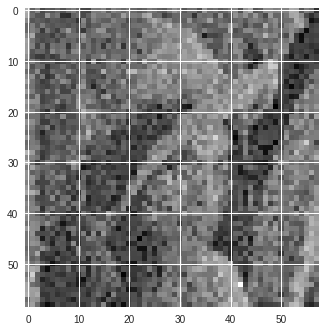

In [35]:
print("Displaying the difference between denoised image and original one...")
plt.imshow(evaluate.Idiff, cmap = plt.get_cmap('gray'))